# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

### 1. Is the distribution of body temperatures normal?
Although the sample data does not follow a normal distribution perfectly, it is close enough based on visual inspection of the data plotted as a histogram with a normal curve overlayed and the results of an anderson-darling test for normality.

In [23]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, anderson, ttest_1samp, sem, t, ttest_ind
from sklearn.utils import resample
from statsmodels.stats.weightstats import ztest
import random

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


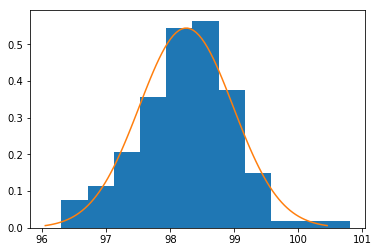

In [25]:
# for visual inspection, create histogram of temperature with a normal curve overlayed
plt.hist(df['temperature'], bins=11, density=True)

# store sample data
sample_mu = df['temperature'].mean()
sample_sigma = df['temperature'].std()
observations = df['temperature'].size
x = np.linspace(sample_mu-3*sample_sigma, sample_mu+3*sample_sigma, 100)
plt.plot(x, norm.pdf(x, sample_mu, sample_sigma))


In [26]:
# Confirm visual inspection of normality using scipy stat's anderson-darling test
print(anderson(df['temperature'], dist='norm'))

AndersonResult(statistic=0.5201038826714353, critical_values=array([0.56 , 0.637, 0.765, 0.892, 1.061]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


### 2. Is the sample size large? Are the observations independent?
There are 130 samples, including 65 female samples and 65 male samples.  The samples are considered independent, as there is no reason to believe the temperature of one person affects the temperature of another.

### 3. Is the true population mean really 98.6 degrees F?
The true population mean is not 98.6 degrees F (null hypothesis).  Three hypothesis tests were performed to answer this question, including a bootstrap hypothesis test, one-sample z-test, and one-sample t-test.  All three provide p-values that are statistically significant, leading to rejection of the null hypothesis.  One-sample z-test and one-sample t-test versus two-sample or paired-sample tests were performed because we are comparing a sample mean to a known population mean (98.6 degrees). The z-test is used because the sample size is considered large enough to safely use the sample variance in lieu of the population variance, which is unknown.  In this case, due to the large sample size,  the t-test provides a p-value is close to the p-value provided under the t-test, and as mentioned previously, both lead to rejection of the null hypothesis.

In [27]:
np.random.seed(42)
def get_bootstrap_replicate(data, func):
    """creates a bootstrap replicate with resampling, accepts a pandas series and a function
    to calculate the test statistic as parameters and returns the bootstrap sample test statistic"""
    
    bootstrap_sample = np.random.choice(data, len(data))
    return func(bootstrap_sample)


def get_bootstrap_pvalue(obs_mean, shifted_data, func, size=100):
    """returns the p-value (1-tail) based on bootstrap replicates and takes as parameters the observation
    mean, data shifted to the null hypothesis mean, function to calculate the test statistic, and size
    or number of bootstrap replicates to use in determining the p-value"""
    
    bootstrap_samples = np.empty(size)
    
    # get bootstrap samples
    for i in range(size):
        bootstrap_samples[i] = get_bootstrap_replicate(shifted_data, np.mean)
    
    # need to multiple this by 2, since test is 'not equal'
    bs_pvalue = (np.sum(bootstrap_samples <= obs_mean))/size
    return bootstrap_samples, bs_pvalue


def get_bootstrap_replicates(data, func, size=100):
    """creates n bootstrap replicates with resampling based on parameter size.  Accepts a pandas series and a function
    to calculate the test statistic as parameters and returns the bootstrap sample test statistic"""
    
    bootstrap_samples = np.empty(size)
    
    # get bootstrap samples
    for i in range(size):
        bootstrap_samples[i] = get_bootstrap_replicate(data, np.mean)
    
    return bootstrap_samples


# perform bootstrap test on the data using 10000 bootstrap replicates
null_mean = 98.6
temps_shifted = df['temperature'] - sample_mu + null_mean
bs_samples, bs_pvalue = get_bootstrap_pvalue(df['temperature'].mean(), temps_shifted, np.mean, 10000)
print('bootstrap p value: ', bs_pvalue)
    
# perform a one sample t_test 
tvalue, t_pvalue = ttest_1samp(df['temperature'], null_mean)
print('t-test p value: ', t_pvalue)

# perform a z-test
z_tvalue, z_pvalue = ztest(df['temperature'], value=null_mean)
print('z-test p value: ', z_pvalue)


bootstrap p value:  0.0
t-test p value:  2.4106320415561276e-07
z-test p value:  4.9021570141012155e-08


### 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

With a small sample size of 10, the use of the z-test is no longer appropriate as the sample variance can no longer be used to approximate the population variance.  Erroneously using this test can lead to falsely rejecting the null hypothesis, a type I error.  Depending on the random sample of 10 below, this can be seen.

In [28]:
# draw small sample of 10 and repeat t-test and z-test
np_temps = np.asarray(df['temperature'])
np.random.shuffle(np_temps)
small_sample = np_temps[:10].tolist()
print('\n REPEAT TESTS WITH SMALL SAMPLE:')

# the below shows that the t and z are off by a couple of hundredths, which could make the difference in acc/rej h0
# t-test with small sample
tvalue_ss, t_pvalue_ss = ttest_1samp(small_sample, null_mean)
print('t-test p value with small sample: ', t_pvalue_ss)

# z-test with small sample
z_tvalue_ss, z_pvalue_ss = ztest(small_sample, value=null_mean)
print('z-test p value with small sample: ', z_pvalue_ss)


 REPEAT TESTS WITH SMALL SAMPLE:
t-test p value with small sample:  0.31428668273507576
z-test p value with small sample:  0.2865318560500928


### 5. At what temperature should we consider someone's temperature to be "abnormal"?

Tempertures below 98.08 degrees and above 98.4 degrees should be considered abnormal.

In [29]:
# confidence intervals

# bootstrap confidence interval:
bs_samples = get_bootstrap_replicates(df['temperature'], np.mean, 10000)
bs_conf_int = np.percentile(bs_samples,[.5,99.5])
print(bs_conf_int)

[98.08615    98.41230769]


In [30]:
# calculate confidence interval using t-distribution critical value
conf = 0.99
std_err = sem(df['temperature'])
bound = std_err * t.ppf((1+conf)/2, sample_mu - 1)

lower_bound = sample_mu - bound
upper_bound = sample_mu + bound

print('lower bound: ', lower_bound, 'upper_bound: ', upper_bound)

lower bound:  98.08028165510915 upper_bound:  98.41817988335241


### 6. Is there a significant difference between males and females in normal temperature?

No.  A two-sample t-test was performed on the mean temperature for females and the mean temperature for males.  This two-sample t-test was appropriate given the small sample size (65 for each group) and because two group means are being compared to determine whether the difference between the two is signficantly significant.  The resulting p-value leads to no rejection of the null hypothesis that the two groups have the same mean.

In [31]:
female_temps = df[df['gender']=='F']['temperature']
male_temps = df[df['gender']=='M']['temperature']

print('female samples: ', female_temps.size)
print('male samples: ', male_temps.size)

t_stat, p_val = ttest_ind(female_temps, male_temps)

print('p value: ', p_val)

female samples:  65
male samples:  65
p value:  0.6684410026669072


### Conclusion

Although the mean normal body temperature has been widely accepted at 98.6 degrees F for more than 120 years, modern analysis using a sample of 130 individuals indicates this is not the correct value and that the mean is actually slightly lower.  Further, the analysis provided above shows that gender does not appear to have any affect on body temperature.
